In [1]:
!pip install arviz
!pip install pymc3==3.8

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 56.9MB/s 
     |████████████████████████████████| 337kB 40.9MB/s 
     |████████████████████████████████| 911kB 2.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
from pymc3 import Poisson, Uniform, Categorical, Normal, MvNormal
from pymc3 import *
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Load data

In [0]:
df_train = pd.read_csv('/content/synthetic-3C2D.csv',index_col=0)
df_train=df_train.reset_index()
w_true = np.array([[1,-2,2],
                  [3,1,0],])
b_true = np.array([-1,5,2]).reshape((1,3))

In [6]:
df_train.columns

Index(['index', 'longitude', 'latitude', 'coordinate', 'true class',
       'feature1', 'feature2', 'true target', 'noisy target'],
      dtype='object')

In [0]:
x = df_train[['feature1', 'feature2']]
y_noisy = df_train['noisy target']

In [0]:
x1 = df_train['feature1']
x2 = df_train['feature2']

#Model with z 

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model:
    #assume five classesa
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    w_1 = Normal('w_1', mu=0, sd=1, shape=(k))
    w_2 = Normal('w_2', mu=0, sd=1, shape=(k))
    b = Normal('b',mu=0,sd=1, shape=(k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', w_1[z])
    w2 = pm.Deterministic('w2', w_2[z])
    b1 = pm.Deterministic('b1', b[z])
    
    y = b1 + w1* x1 + w2*x2
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y, sd=σ, observed=y_noisy)

In [0]:
with model:
    trace = pm.sample(10000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, b, w_2, w_1, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [49:22<00:00, 10.13draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19cc1506d8>,
      dtype=object)

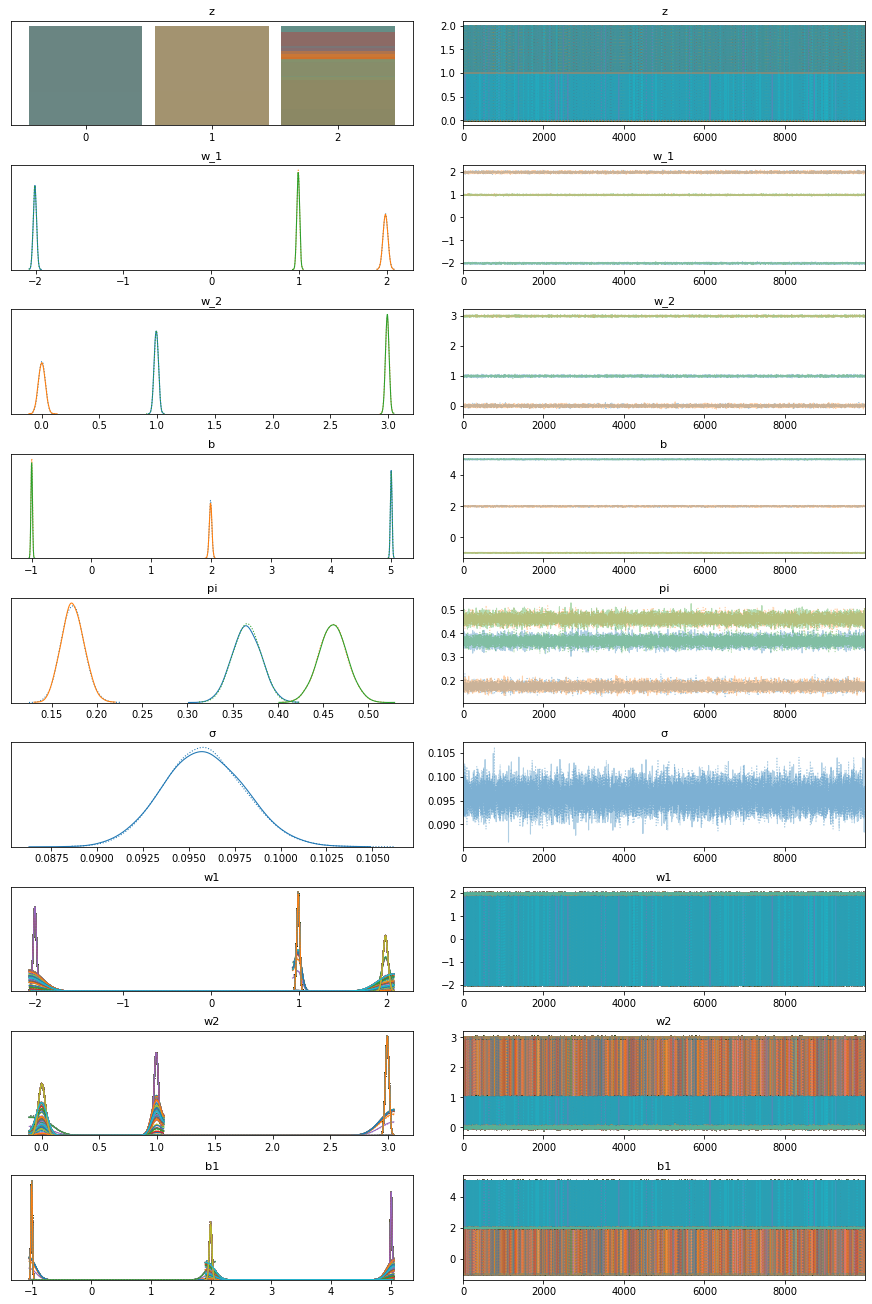

In [0]:
pm.traceplot(trace)

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bce74390>,
      dtype=object)

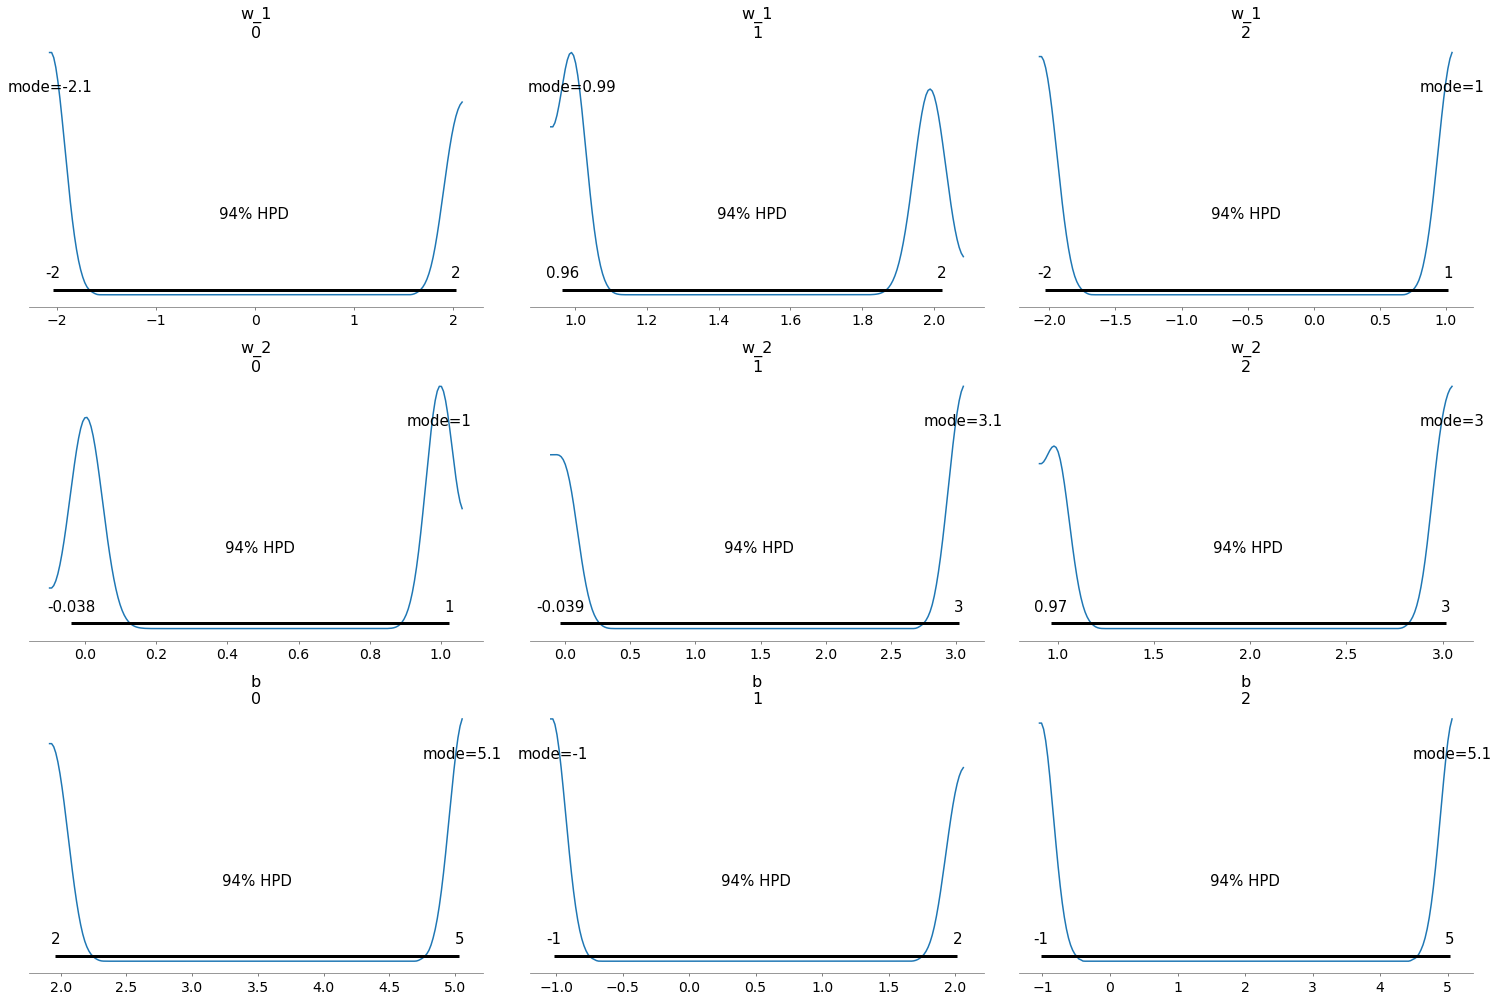

In [0]:
pm.plot_posterior(trace,varnames=['w_1','w_2','b'], point_estimate='mode')

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bdb25898>,
      dtype=object)

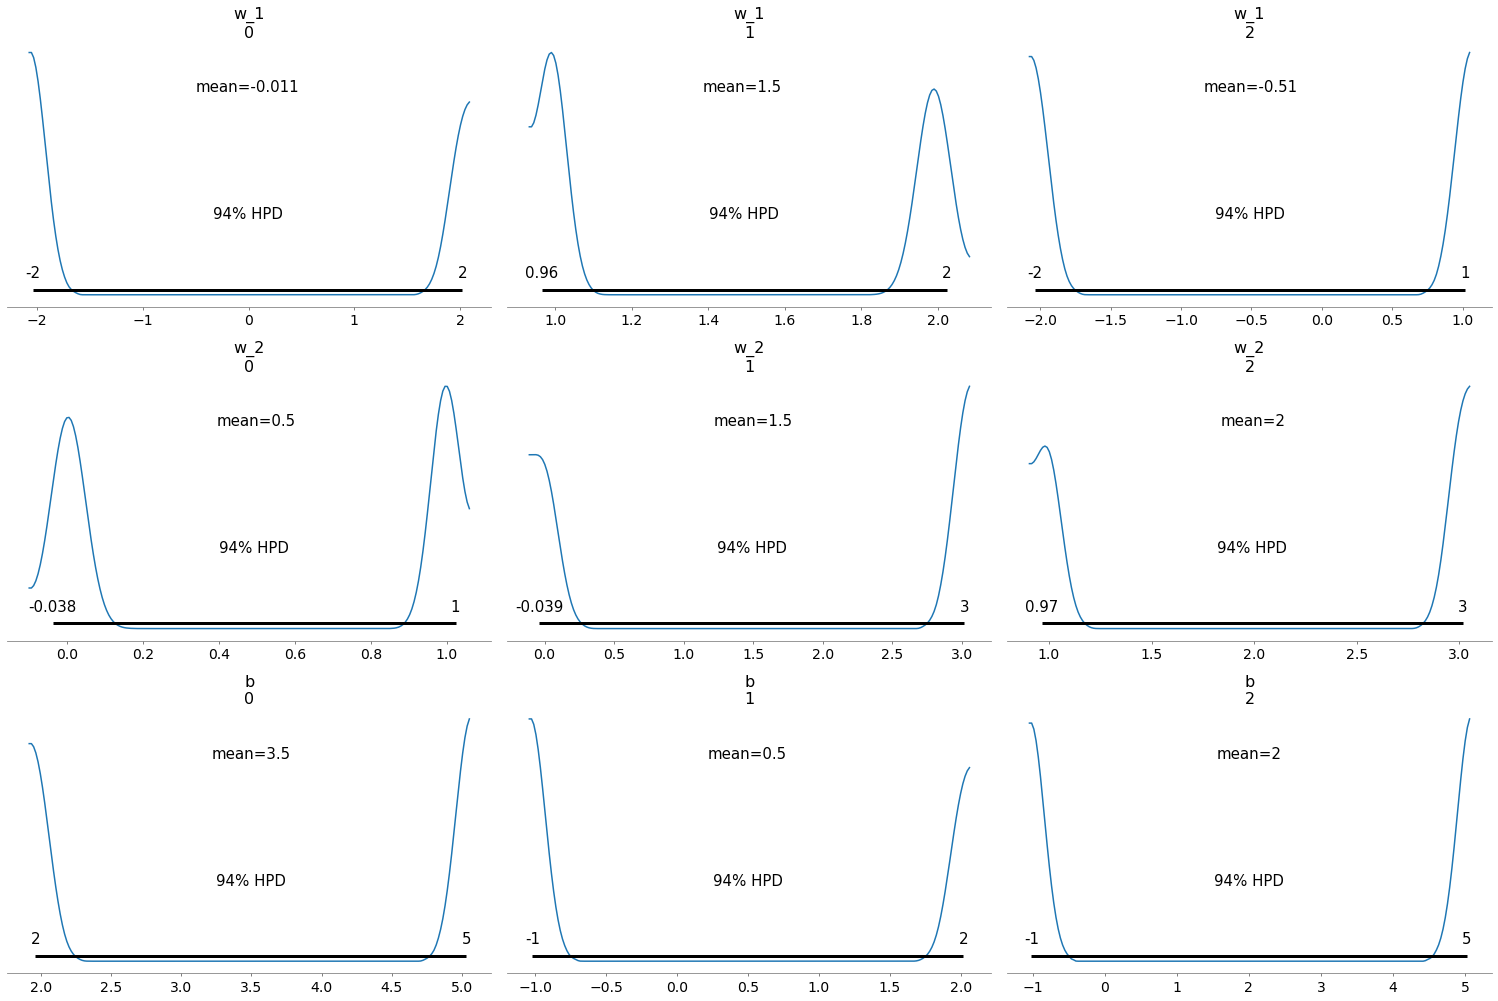

In [0]:
pm.plot_posterior(trace,varnames=['w_1','w_2','b'], point_estimate='mean')

In [0]:
w_true, b_true

(array([[ 1, -2,  2],
        [ 3,  1,  0]]), array([[-1,  5,  2]]))

In [0]:
w1_map

array([ 2.,  1., -2.])

In [0]:
w1_map = trace['w_1'][-5000:].mean(axis=0).round()

In [0]:
w2_map = trace['w_2'][-5000:].mean(axis=0).round()

In [0]:
b_map = trace['b'][-5000:].mean(axis=0).round()

In [0]:
from scipy import stats
z_map, counts = stats.mode(trace['z'][-5000:,:])
z_map = z_map.flatten()
confidence = np.round((counts/5000),decimals=2).reshape(1000,)
y_pred = (b_map[z_map]) + w1_map[z_map]*(x1.values) + w2_map[z_map]*(x2.values) 

In [0]:
df_model1 = df_train.copy()
df_model1['predicted z'] = z_map
df_model1['confidence'] = confidence
df_model1['predicted y'] = y_pred

In [0]:
df_model1['reordered predicted z'] = (df_model1['predicted z']+1).map({1:3,2:1,3:2})

In [0]:
df_model1['reordered predicted z'] .value_counts()

1    462
2    370
3    168
Name: reordered predicted z, dtype: int64

In [0]:
df_model1['true class'].value_counts()

1    462
2    363
3    175
Name: true class, dtype: int64

In [0]:
df_model1.to_csv('model1-3C2D.csv')

## confusion matrix of predicted z

In [0]:
y_actual = df_model1['true class']
y_pred = df_model1['reordered predicted z']

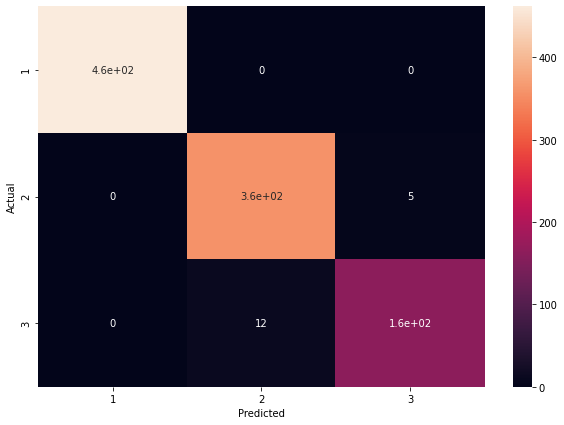

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
y_actu = pd.Series(y_actual.values, name='Actual')
y_pred = pd.Series(y_pred.values, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(df_confusion, annot=True)

## confidence of z

In [0]:
df_model1['confidence'].describe()

count    1000.000000
mean        0.985610
std         0.067263
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: confidence, dtype: float64

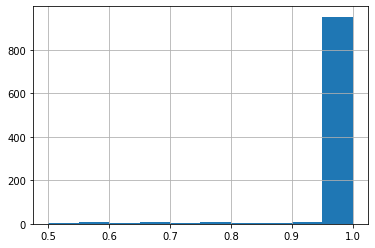

In [0]:
df_model1['confidence'].hist()

# Reconstruction of partition

In [12]:
pip install geopandas

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 10.4MB 14.7MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [0]:
df_model = df_model.sort_values(by='reordered predicted z', ascending=True)

In [0]:
df_model = pd.read_csv('model1-3C2D.csv',index_col=0)
coords = df_model[['longitude','latitude']].values.tolist()
longitude = df_model['longitude'].values
latitude = df_model['latitude'].values
predicted_class = df_model['reordered predicted z'].values
color = ['g','b','r']
color_array = [color[c-1] for c in predicted_class]

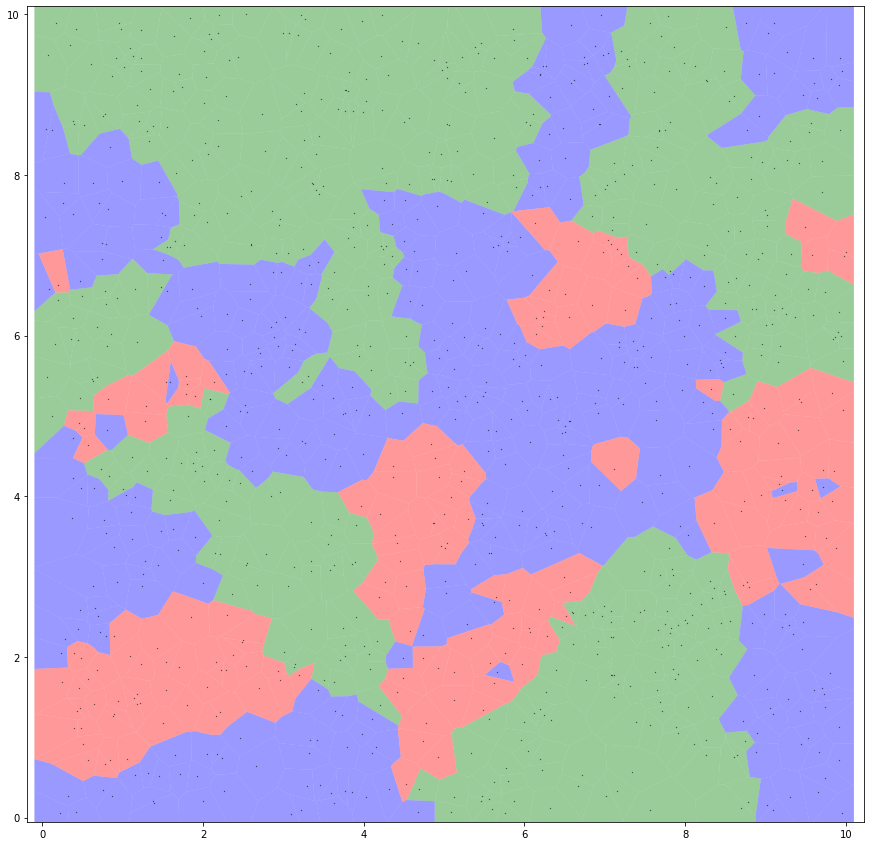

In [112]:
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
import geopandas
from scipy.spatial import Voronoi

vor = Voronoi(coords)
regions, vertices = voronoi_finite_polygons_2d(vor)
plt.figure(figsize=(15,15))

box = Polygon([[-0.1, -0.1], [-.1, 10.1], [10.1, 10.1], [10.1, -0.1],[-0.1,-0.1]])


polygons = []
i=0
# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    polygons.append(Polygon(poly.exterior))

    plt.fill(*zip(*polygon),color_array[i], alpha=0.4)
    i+=1

plt.plot(longitude, latitude, 'k.', markersize=0.5)
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voro-predicted-model1.png')
plt.show()

In [0]:
df_model['reordered predicted z'].value_counts()

In [0]:
from shapely.ops import cascaded_union
region1_predicted = cascaded_union(polygons[0:462])
region2_predicted = cascaded_union(polygons[462:825])
region3_predicted = cascaded_union(polygons[825:1000])
polygons_predicted = [region1_predicted ,region2_predicted,region3_predicted]

In [0]:
df_predicted_partition = geopandas.GeoDataFrame()
df_predicted_partition['predicted class'] = [1,2,3]
df_predicted_partition['polygons'] = polygons_predicted
df_predicted_partition.to_csv('/content/synthetic-predicted-partition-model1.csv')

# Load ground truth to compare

In [0]:
df_gt = pd.read_csv('/content/synthetic-groundTruth.csv')
from shapely.wkt import loads
df_gt['polygons'] = df_gt['polygons'].apply(loads)

polygons_gt = df_gt['polygons'].values
region1 = df_gt['polygons'][0]
region2 = df_gt['polygons'][1]
region3 = df_gt['polygons'][2]

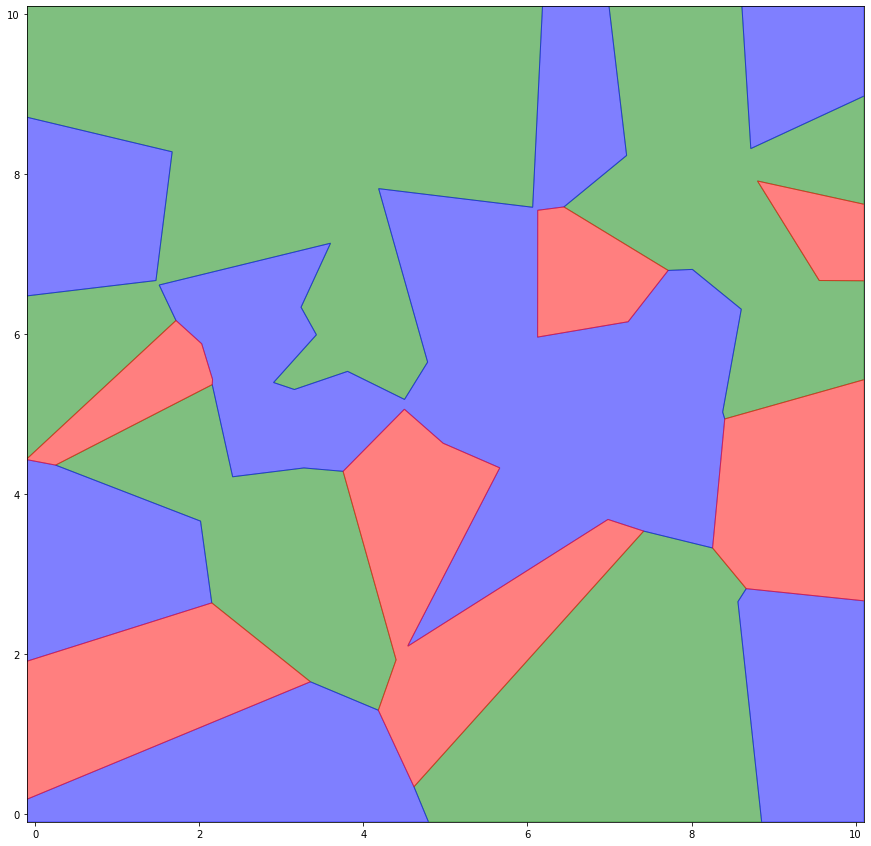

In [56]:
fig, axs = plt.subplots(figsize=(15,15))
color = ['g','b','r']
i=0
for p in polygons_gt:
  c = color[i]
  i += 1
  for geom in p.geoms:    
      xs, ys = geom.exterior.xy    
      axs.fill(xs, ys, alpha=0.5, color=c, ec='none')


plt.xlim(- 0.1, 10.1)
plt.ylim(- 0.1, 10.1)
plt.show()


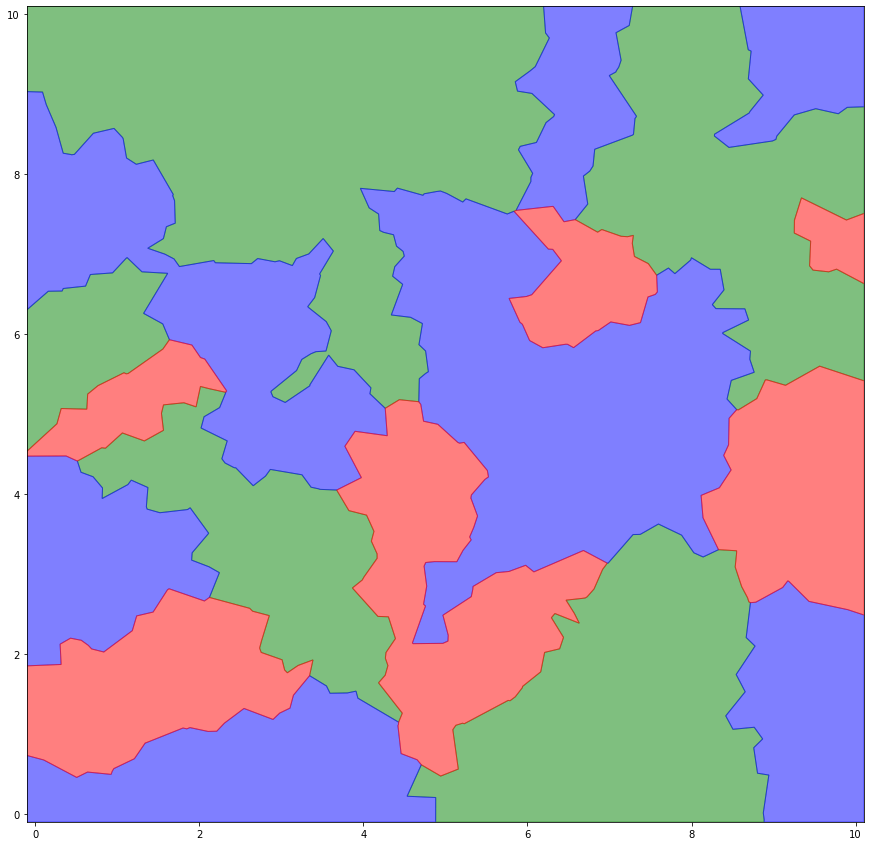

In [160]:
fig, axs = plt.subplots(figsize=(15,15))
color = ['g','b','r']
i=0
for p in polygons_predicted:
  c = color[i]
  i += 1
  for geom in p.geoms:    
      xs, ys = geom.exterior.xy    
      axs.fill(xs, ys, alpha=0.5, color=c, ec='none')

# plt.plot(longitude,latitude,'k.',markersize=0.5)
plt.xlim(- 0.1, 10.1)
plt.ylim(- 0.1, 10.1)
plt.show()

## plot intersection

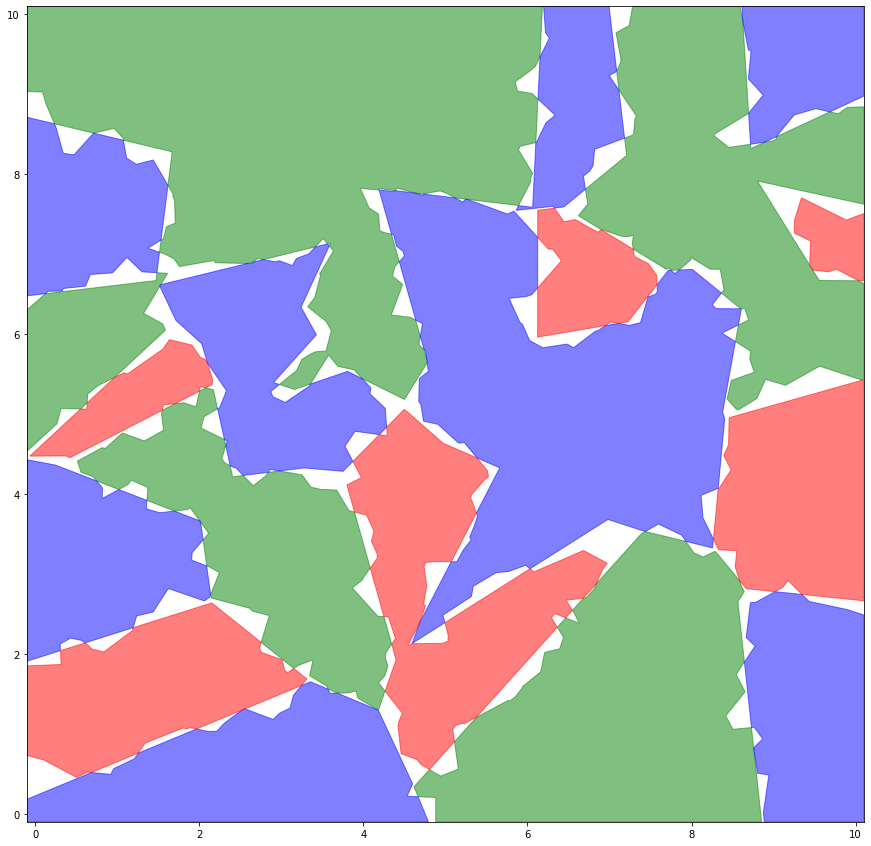

In [184]:
fig, axs = plt.subplots(figsize=(15,15))
color = ['g','b','r']
i=0
for p in [region1.intersection(region1_predicted),
          region2.intersection(region2_predicted),
          region3.intersection(region3_predicted)]:
  c = color[i]
  i += 1
  for geom in p.geoms:    
      xs, ys = geom.exterior.xy    
      axs.fill(xs, ys, alpha=0.5, color=c, ec='none')

# plt.plot(longitude,latitude,'k.',markersize=0.5)
plt.xlim(- 0.1, 10.1)
plt.ylim(- 0.1, 10.1)
plt.show()

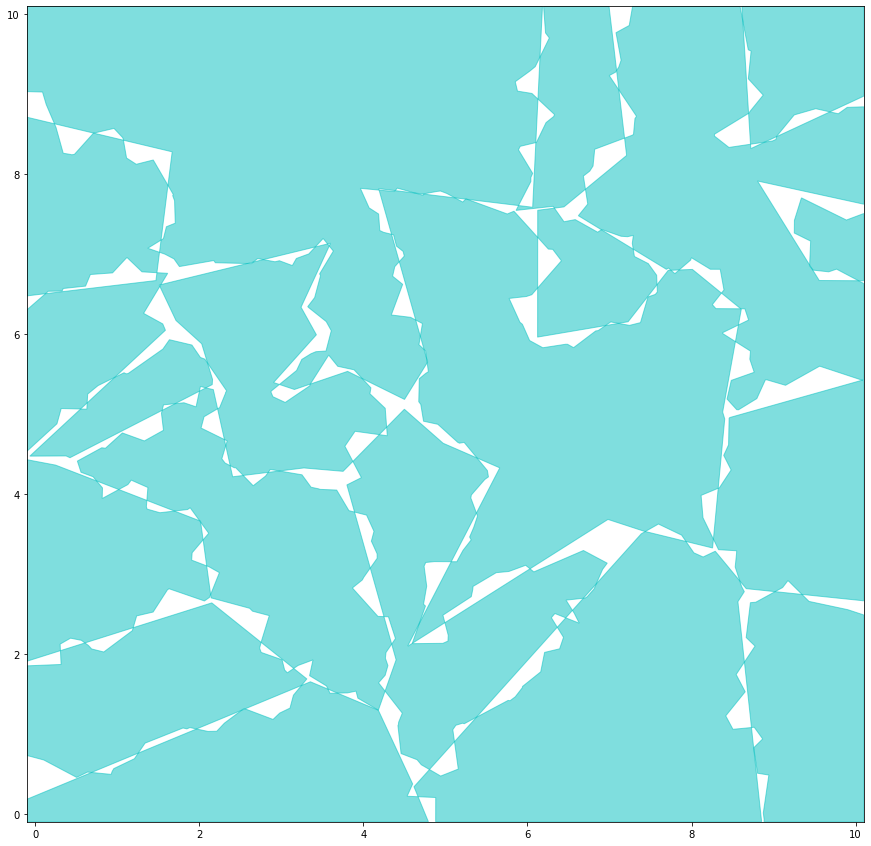

In [187]:
fig, axs = plt.subplots(figsize=(15,15))
for p in [region1.intersection(region1_predicted),
          region2.intersection(region2_predicted),
          region3.intersection(region3_predicted)]:
  for geom in p.geoms:    
      xs, ys = geom.exterior.xy    
      axs.fill(xs, ys, alpha=0.5, color='c', ec='none')

# plt.plot(longitude,latitude,'k.',markersize=0.5)
plt.xlim(- 0.1, 10.1)
plt.ylim(- 0.1, 10.1)
plt.show()

In [0]:
true_area_1 = region1.intersection(region1_predicted).area
true_area_2 = region2.intersection(region2_predicted).area
true_area_3 = region3.intersection(region3_predicted).area

In [0]:
df_predicted_partition['ground truth polygon'] = polygons_gt

In [0]:
df_predicted_partition['ground truth polygon area'] = [p.area for p in polygons_gt]
df_predicted_partition['predicted polygon area'] = [p.area for p in polygons_predicted]
df_predicted_partition['intersection of predicted and ground truth area'] = [true_area_1,true_area_2,true_area_3]

In [0]:
df_predicted_partition['true area/ GT area(recall)'] =df_predicted_partition['intersection of predicted and ground truth area']/ df_predicted_partition['ground truth polygon area']

In [0]:
df_predicted_partition['true area/ predicted area(precision)'] = df_predicted_partition['intersection of predicted and ground truth area']/ df_predicted_partition['predicted polygon area']

In [200]:
df_predicted_partition

,predicted class,polygons,ground truth polygon,ground truth polygon area,predicted polygon area,intersection of predicted and ground truth area,true area/ GT area(recall),true area/ predicted area(precision)
0,1,"(POLYGON ((6.065155547662238 -0.1, 5.623976486...","(POLYGON ((8.56566323210442 2.653341460878206,...",46.505103,45.325436,43.004261,0.924721,0.948789
1,2,(POLYGON ((4.534253804779671 0.219803715640550...,"(POLYGON ((-0.1 0.1814478634791331, 3.35590521...",38.224032,39.033868,35.419440,0.926628,0.907403
2,3,(POLYGON ((0.9409789163775182 0.53264420842908...,"(POLYGON ((-0.1 1.908078845191928, 2.153945885...",19.310865,19.680696,17.060277,0.883455,0.866853


In [203]:
average_precision = np.sum([true_area_1,true_area_2,true_area_3])/100
average_precision

0.9548397837240579

# Prediction on testing data

In [0]:
df_test = pd.read_csv('/content/synthetic-3C2D-test.csv')

In [0]:
df_test['coordinate'] = df_test['coordinate'].apply(loads)

In [0]:
points = df_test['coordinate'].values
polygons = df_predicted_partition['polygons'].values
z = df_predicted_partition['predicted class'].values
classes = []
for point in points:
  for i in range(len(polygons)):
    if polygons[i].contains(point):
      classes.append(z[i])

df_test['predicted class'] = classes

In [0]:
x = df_test[['feature1','feature2']].values
w_map = np.array([[ 1, -2,  2],[ 3,  1,  0]])
b_map = np.array([[-1,  5,  2]])
y = df_test['noisy target'].values
y_pred = (np.dot(x,w_map[:,(np.array(classes)-1)]).diagonal()).reshape(-1,1)
df_test['predicted target with model 1'] = y_pred
df_test['predicted class with model 1'] = classes

In [0]:
df_test.to_csv('synthetic-3C2D-test-prediction-model1')

### accuracy on class prediction

In [243]:
(df_test['predicted class with model 1'] == df_test['true class']).value_counts()/200

True     0.91
False    0.09
dtype: float64

### RMSE

In [236]:
np.square(y-y_pred).mean()

7.55436406198889